In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools
import pathlib
import os
import anndata as ad
import scimap as sm
import matplotlib.colors as colors
import seaborn as sns
import matplotlib.patches as mpatches
plt.rcParams['pdf.fonttype'] = 42


Running SCIMAP  2.2.11


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [30]:
def distPlot(
    adata,
    layer=None,
    markers=None,
    subset=None,
    imageid='imageid',
    vline=None,
    vlinewidth=None,
    plotGrid=True,
    ncols=None,
    color=None,
    xticks=None,
    figsize=(5, 5),
    fontsize=None,
    dpi=200,
    saveDir=None,
    fileName='scimapDistPlot.png',
):
    """
    Parameters:
        adata (anndata.AnnData):
            Annotated data object.

        layer (str, optional):
            Layer of data to plot.

        markers (list, optional):
            List of marker genes to plot.

        subset (list or None, optional):
            `imageid` of a single or multiple images to be subsetted for plotting purposes.

        imageid (str, optional):
            The column name in `spatial feature table` that contains the image ID
            for each cell.

        vline (float or 'auto', optional):
            The x-coordinate of the vertical line to plot. If set to `None`, a vertical line is not plotted.
            Use 'auto' to draw a vline at the center point.

        plotGrid (bool, optional):
            Whether to plot each marker in it's own sub plot. If `False` and multiple markers
            are passed in via `markers`, all distributions will be plotted within a single plot.

        ncols (int, optional):
            The number of columns in the final plot when multiple variables are plotted.

        color (str, optional):
            Color of the distribution plot.

        xticks (list of float, optional):
            Custom x-axis tick values.

        figsize (tuple, optional):
            Figure size. Defaults to (5, 5).

        fontsize (int, optional):
            The size of the font of the axis labels.

        dpi (int, optional):
            The DPI of the figure. Use this to control the point size. Lower the dpi, larger the point size.

        saveDir (str, optional):
            The directory to save the output plot.

        fileName (str, optional):
            The name of the output file. Use desired file format as suffix (e.g. `.png` or `.pdf`).

    Returns:
        Plot (image):
            If `outputDir` is provided the plot will saved within the provided outputDir.

    Example:
            ```python

            sm.pl.distPlot(adata,
                         layer=None,
                         markers=['CD45','CD3D','CD20'],
                         plotGrid=True,
                         ncols=5)
            ```

    """

    # testing
    # layers=None; markers=None; plotGrid=True; ncols=None; color=None; figsize=(10, 10); fontsize=None; subset=None; imageid='imageid'; xticks=None; dpi=200; outputDir=None;
    # outputFileName='distPlot.png'
    # color = {'markerA': '#000000', 'markerB': '#FF0000'}
    # outputDir = r"C:\Users\aj\Downloads"

    # subset data if neede
    if subset is not None:
        if isinstance(subset, str):
            subset = [subset]
        if layer == 'raw':
            bdata = adata.copy()
            bdata.X = adata.raw.X
            bdata = bdata[bdata.obs[imageid].isin(subset)]
        else:
            bdata = adata.copy()
            bdata = bdata[bdata.obs[imageid].isin(subset)]
    else:
        bdata = adata.copy()

    # isolate the data
    if layer is None:
        data = pd.DataFrame(bdata.X, index=bdata.obs.index, columns=bdata.var.index)
    elif layer == 'raw':
        data = pd.DataFrame(bdata.raw.X, index=bdata.obs.index, columns=bdata.var.index)
    else:
        data = pd.DataFrame(
            bdata.layers[layer], index=bdata.obs.index, columns=bdata.var.index
        )

    # keep only columns that are required
    if markers is not None:
        if isinstance(markers, str):
            markers = [markers]
        # subset the list
        data = data[markers]

    # auto identify rows and columns in the grid plot
    def calculate_grid_dimensions(num_items, num_columns=None):
        """
        Calculates the number of rows and columns for a square grid
        based on the number of items.
        """
        if num_columns is None:
            num_rows_columns = int(math.ceil(math.sqrt(num_items)))
            return num_rows_columns, num_rows_columns
        else:
            num_rows = int(math.ceil(num_items / num_columns))
            return num_rows, num_columns

    if plotGrid is False:
        # Create a figure and axis object
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
        # Loop through each column in the DataFrame and plot a KDE with the
        # user-defined color or the default color (grey)
        if color is None:
            for column in data.columns:
                data[column].plot.kde(ax=ax, label=column)
        else:
            for column in data.columns:
                c = color.get(column, 'grey')
                data[column].plot.kde(ax=ax, label=column, color=c)
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=fontsize)
        ax.tick_params(axis='both', which='major', width=1, labelsize=fontsize)
        plt.tight_layout()
        if xticks is not None:
            ax.set_xticks(xticks)
            ax.set_xticklabels([str(x) for x in xticks])

        if vline == 'auto':
            ax.axvline((data[column].max() + data[column].min()) / 2, color='black')
        elif vline is None:
            pass
        else:
            ax.axvline(vline, color='black')

        # save figure
        if outputDir is not None:
            plt.savefig(pathlib.Path(outputDir) / outputFileName)

    else:
        # calculate the number of rows and columns
        num_rows, num_cols = calculate_grid_dimensions(
            len(data.columns), num_columns=ncols
        )

        # set colors
        if color is None:
            # Define a color cycle of 10 colors
            color_cycle = itertools.cycle(
                plt.rcParams['axes.prop_cycle'].by_key()['color']
            )
            # Assign a different color to each column
            color = {col: next(color_cycle) for col in data.columns}

        # Set the size of the figure
        fig, axes = plt.subplots(
            nrows=num_rows, ncols=num_cols, figsize=figsize, dpi=dpi
        )
        axes = np.atleast_2d(axes)
        # Set the spacing between subplots
        # fig.subplots_adjust(bottom=0.1, hspace=0.1)

        # Loop through each column in the DataFrame and plot a KDE with the
        # user-defined color or the default color (grey) in the corresponding subplot
        for i, column in enumerate(data.columns):
            c = color.get(column, 'grey')
            row_idx = i // num_cols
            col_idx = i % num_cols
            data[column].plot.kde(ax=axes[row_idx, col_idx], label=column, color=c)
            axes[row_idx, col_idx].set_title(column)
            axes[row_idx, col_idx].tick_params(
                axis='both', which='major', width=1, labelsize=fontsize
            )
            axes[row_idx, col_idx].set_ylabel('')

            if vline == 'auto':
                axes[row_idx, col_idx].axvline(
                    (data[column].max() + data[column].min()) / 2, color='gray', dashes=[2, 2], linewidth=1
                )
                if vlinewidth is not None:
                    axes[row_idx, col_idx].axvline(
                        (data[column].max() + data[column].min()) / 2,color='gray', dashes=[2, 2], linewidth=vlinewidth)
            elif vline is None:
                pass
            else:
                axes[row_idx, col_idx].axvline(vline, color='black')

            if xticks is not None:
                axes[row_idx, col_idx].set_xticks(xticks)
                axes[row_idx, col_idx].set_xticklabels([str(x) for x in xticks])

        # Remove any empty subplots
        num_plots = len(data.columns)
        for i in range(num_plots, num_rows * num_cols):
            row_idx = i // num_cols
            col_idx = i % num_cols
            fig.delaxes(axes[row_idx, col_idx])

        # Set font size for tick labels on both axes
        plt.tick_params(axis='both', labelsize=fontsize)
        plt.tight_layout()

        # Save the figure to a file
        if saveDir:
            if not os.path.exists(saveDir):
                os.makedirs(saveDir)
            full_path = os.path.join(saveDir, fileName)
            plt.savefig(full_path, dpi=300)
            plt.close()
            print(f"Saved heatmap to {full_path}")
        else:
            plt.show()

In [ ]:
adata = ad.read_h5ad('/Volumes/FallahiLab/Maize-Data/Leica-Thunder/Kimberly_Nguyen/20240624_HetMel/FA3-2/2025_analysis/8rounds_naparigater_excluded-low-counts_spatial_v4.h5ad')

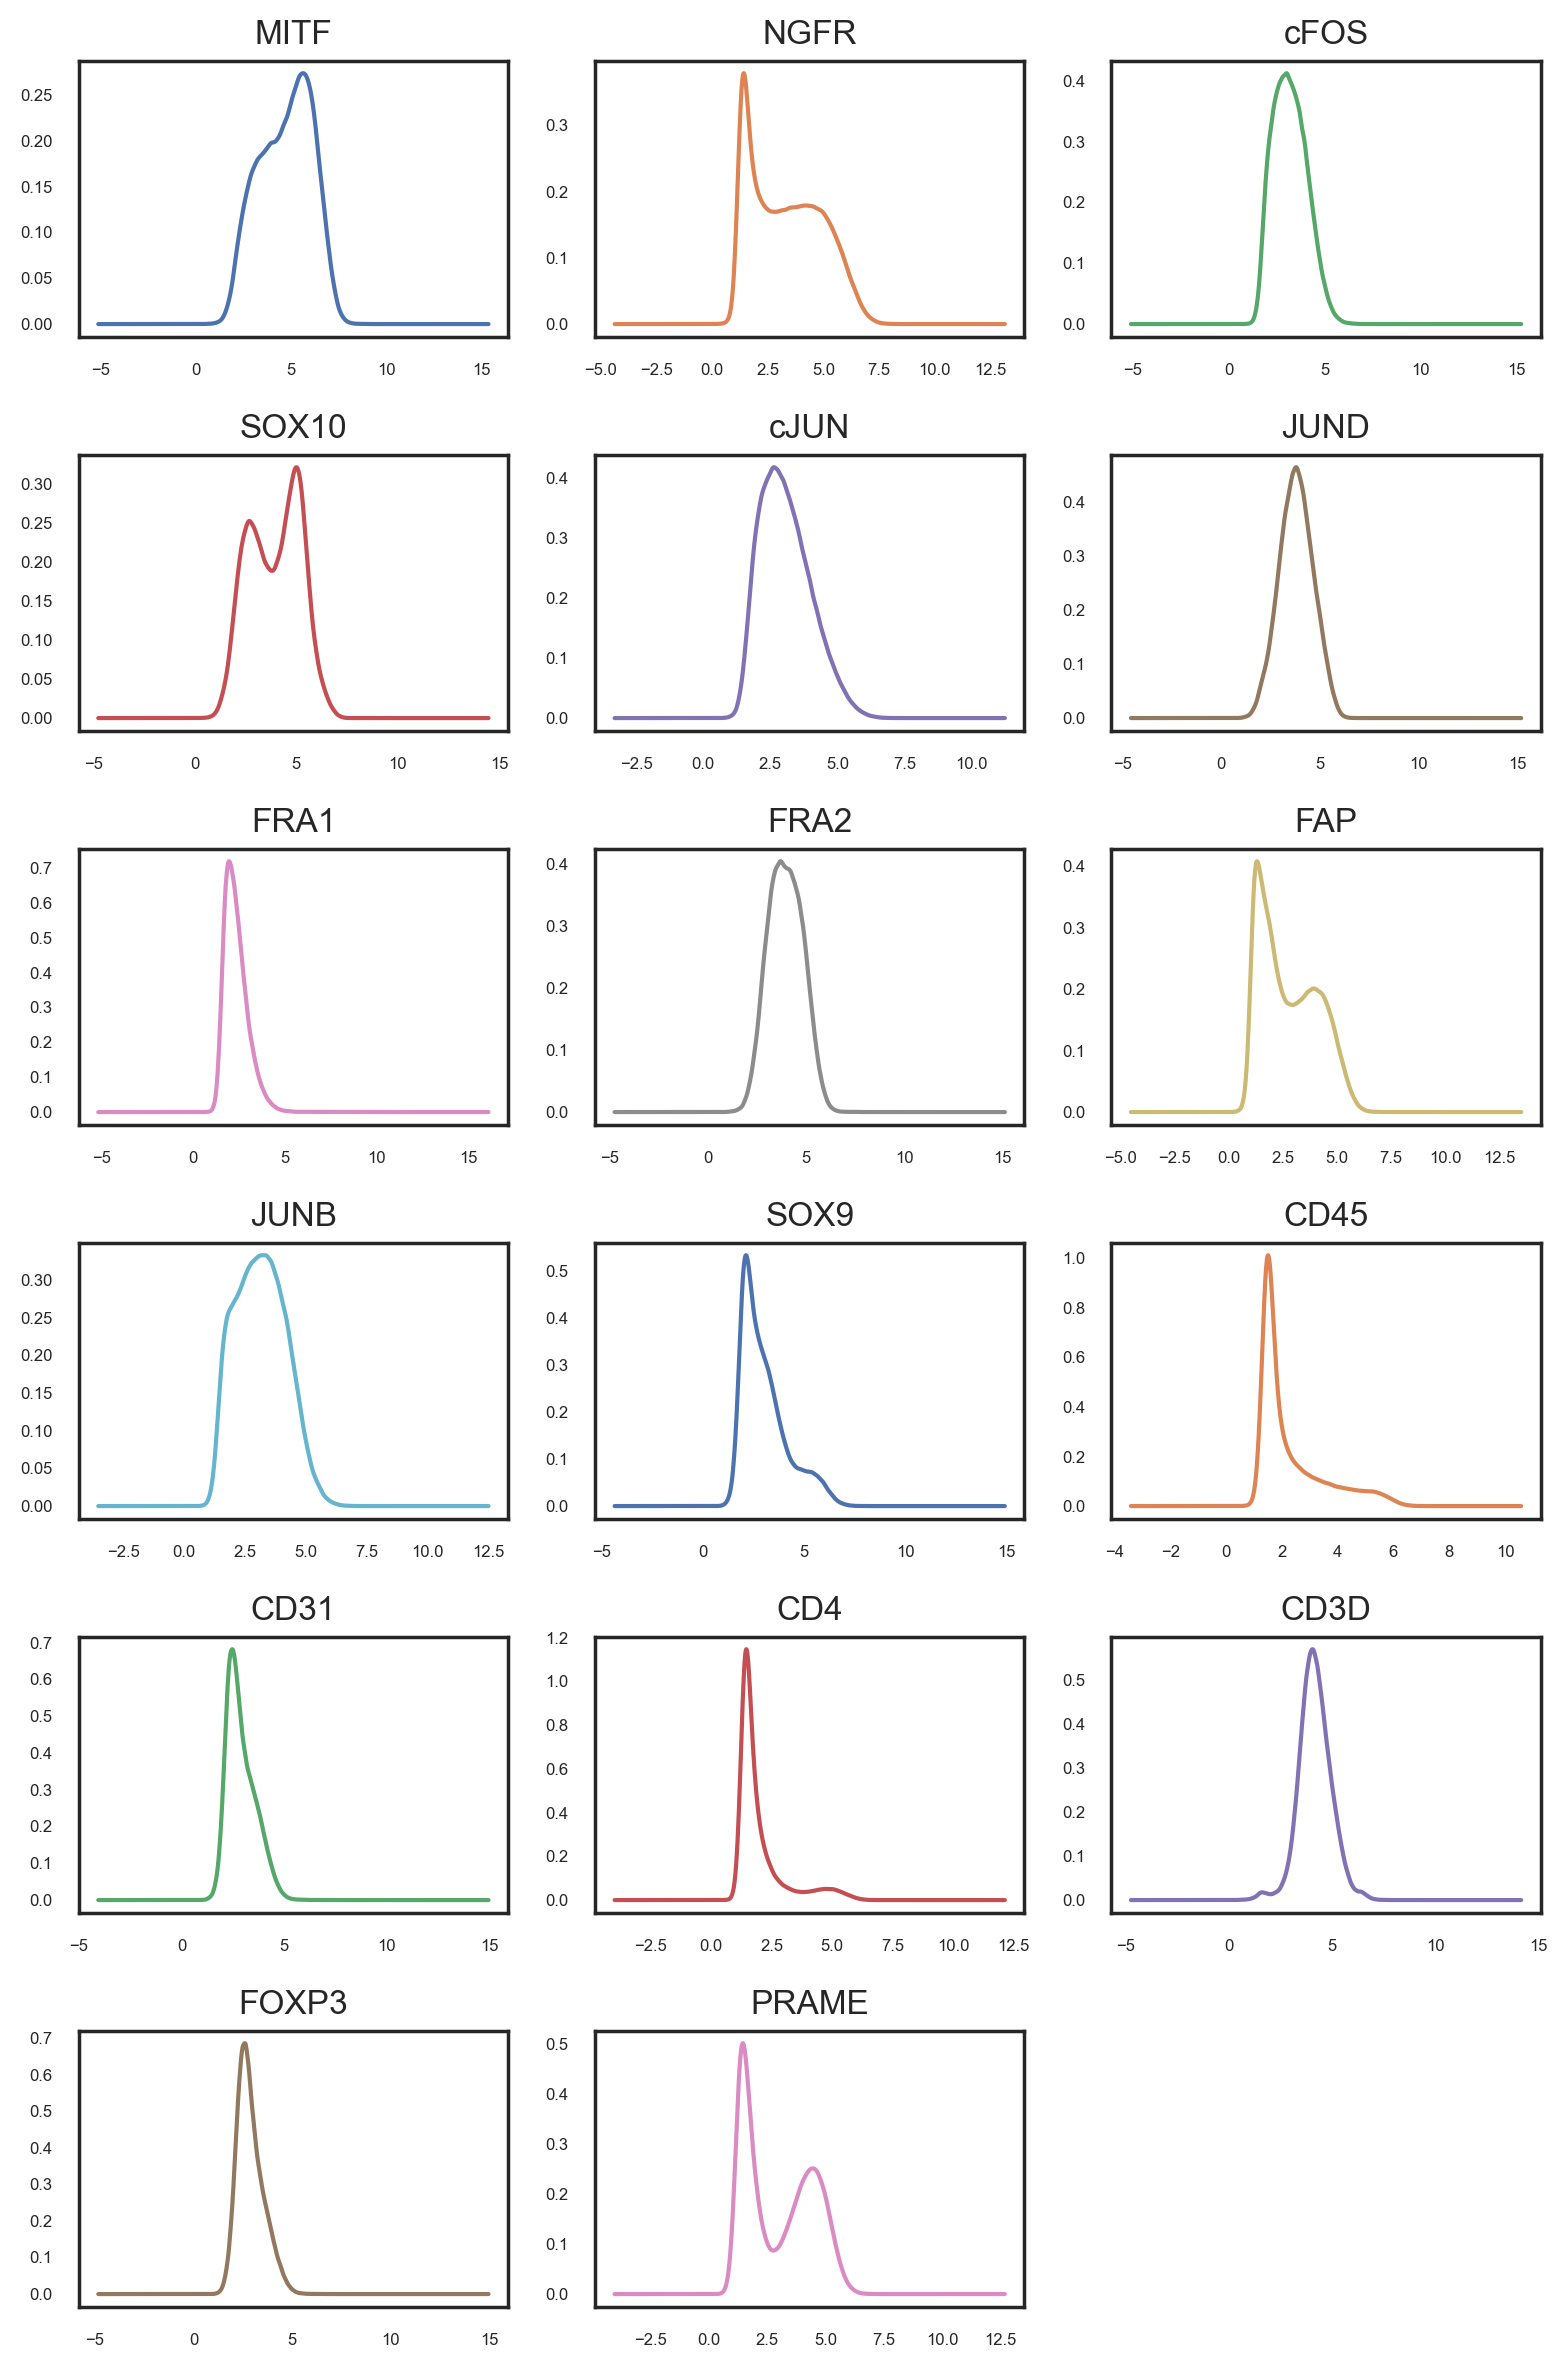

In [ ]:
distPlot(adata, layer="log1p_raw", vline =                                                                                                                                                                 None, markers=['MITF', 'NGFR', 'cFOS', 'SOX10', 'cJUN', 'JUND', 'FRA1', 'FRA2',
       'FAP', 'JUNB', 'SOX9', 'CD45', 'CD31', 'CD4', 'CD3D', 'FOXP3',
       'PRAME'], ncols=3, fontsize=6, figsize=(8,12),vlinewidth=1)

In [55]:
def umap(
    adata,
    color=None,
    layer=None,
    subset=None,
    standardScale=False,
    use_raw=False,
    log=False,
    label='umap',
    cmap='vlag',
    palette=None,
    alpha=0.8,
    figsize=(5, 5),
    s=None,
    ncols=None,
    tight_layout=False,
    return_data=False,
    saveDir=None,
    fileName='umap.pdf',
    **kwargs,
):
    """
    Parameters:
            adata (anndata.AnnData):
                The annotated data matrix.

            color (list, optional):
                List of keys from `adata.obs.columns` or `adata.var.index` to color the plot.
                Allows multiple keys for facetted plotting.

            layer (str, optional):
                Specifies the AnnData layer to use for UMAP calculations. Defaults to using `adata.X`.

            use_raw (bool, optional):
                If True, uses `adata.raw.X` for coloring the plot, useful for visualizing gene expression on UMAP.

            log (bool, optional):
                Applies log transformation (`np.log1p`) to the data before plotting. Useful for gene expression data.

            label (str, optional):
                Key in `adata.obsm` where UMAP coordinates are stored.

            cmap (str, optional):
                Colormap for continuous variables. Supports matplotlib colormap names and objects.

            palette (dict, optional):
                Specific colors for different categories as a dictionary mapping from categories to colors.

            alpha (float, optional):
                Transparency level of the points. Ranges from 0 (transparent) to 1 (opaque).

            figsize (tuple, optional):
                Figure size specified as (width, height) in inches.

            s (int, optional):
                Size of the points in the plot.

            ncols (int, optional):
                Number of columns for facetted plotting.

            tight_layout (bool, optional):
                Adjusts subplot params for a tight layout.

            return_data (bool, optional):
                If True, returns the DataFrame containing data used for plotting instead of displaying the plot.

            saveDir (str, optional):
                Path and filename to save the figure. File extension determines the format (e.g., `.pdf`, `.png`).

            **kwargs:
                Additional keyword arguments passed to matplotlib plot function.

    Returns:
            Plot (matplotlib):
                    Optionally returns the data used for plotting if `return_data=True`.

    Example:
        ```python

        # Basic UMAP visualization with default settings
        sm.pl.umap(adata, color='cell_type')

        # UMAP visualization with log transformation and custom colormap
        sm.pl.umap(adata, color='gene_expression', log=True, cmap='coolwarm')

        # Facetted UMAP plotting with custom point size and saved figure
        sm.pl.umap(adata, color=['cell_type', 'condition'], s=100, figsize=(10, 5), save_figure='/path/to/umap_plot.png')

        ```
    """

    # check if umap tool has been run
    try:
        adata.obsm[label]
    except KeyError:
        raise KeyError("Please run `sm.tl.umap(adata)` first")



    # identify the coordinates
    umap_coordinates = pd.DataFrame(
        adata.obsm[label], index=adata.obs.index, columns=['umap-1', 'umap-2']
    )

    # other data that the user requests
    if color is not None:
        if isinstance(color, str):
            color = [color]
        # identify if all elemets of color are available
        if (
            set(color).issubset(list(adata.var.index) + list(adata.obs.columns))
            is False
        ):
            raise ValueError(
                "Element passed to `color` is not found in adata, please check!"
            )

        # organise the data
        if any(item in color for item in list(adata.obs.columns)):
            adataobs = adata.obs.loc[:, adata.obs.columns.isin(color)]
            adataobs = adataobs.apply(lambda x: x.astype('category'))

        else:
            adataobs = None

        if any(item in color for item in list(adata.var.index)):
            # find the index of the marker
            marker_index = np.where(np.isin(list(adata.var.index), color))[0]
            if layer is not None:
                adatavar = adata.layers[layer][:, np.r_[marker_index]]
            elif use_raw is True:
                adatavar = adata.raw.X[:, np.r_[marker_index]]
            else:
                adatavar = adata.X[:, np.r_[marker_index]]
            adatavar = pd.DataFrame(
                adatavar,
                index=adata.obs.index,
                columns=list(adata.var.index[marker_index]),
            )
        else:
            adatavar = None

        #if standardScale is True:
        #    if adatavar is not None:
         #       adatavar = adatavar.apply(lambda x: (x - x.mean()) / x.std(), axis=0)


        # combine all color data
        if adataobs is not None and adatavar is not None:
            color_data = pd.concat([adataobs, adatavar], axis=1)
        elif adataobs is not None and adatavar is None:
            color_data = adataobs
        elif adataobs is None and adatavar is not None:
            color_data = adatavar
    else:
        color_data = None

    # combine color data with umap coordinates
    if color_data is not None:
        final_data = pd.concat([umap_coordinates, color_data], axis=1)
    else:
        final_data = umap_coordinates

    
    
    # create some reasonable defaults
    # estimate number of columns in subpolt
    nplots = len(final_data.columns) - 2  # total number of plots
    if ncols is None:
        if nplots >= 4:
            subplot = [math.ceil(nplots / 4), 4]
        elif nplots == 0:
            subplot = [1, 1]
        else:
            subplot = [math.ceil(nplots / nplots), nplots]
    else:
        subplot = [math.ceil(nplots / ncols), ncols]

    if nplots == 0:
        n_plots_to_remove = 0
    else:
        n_plots_to_remove = (
            np.prod(subplot) - nplots
        )  # figure if we have to remove any subplots

    # size of points
    if s is None:
        if nplots == 0:
            s = 100000 / adata.shape[0]
        else:
            s = (100000 / adata.shape[0]) / nplots

    # if there are categorical data then assign colors to them
    if final_data.select_dtypes(exclude=["number", "bool_", "object_"]).shape[1] > 0:
        # find all categories in the dataframe
        cat_data = final_data.select_dtypes(exclude=["number", "bool_", "object_"])
        # find all categories
        all_cat = []
        for i in cat_data.columns:
            all_cat.append(list(cat_data[i].cat.categories))

        # generate colormapping for all categories
        less_9 = [colors.rgb2hex(x) for x in sns.color_palette('Set1')]
        nineto20 = [colors.rgb2hex(x) for x in sns.color_palette('tab20')]
        greater20 = [
            colors.rgb2hex(x)
            for x in sns.color_palette('gist_ncar', max([len(i) for i in all_cat]))
        ]

        all_cat_colormap = dict()
        for i in range(len(all_cat)):
            if len(all_cat[i]) <= 9:
                dict1 = dict(zip(all_cat[i], less_9[: len(all_cat[i])]))
            elif len(all_cat[i]) > 9 and len(all_cat[i]) <= 20:
                dict1 = dict(zip(all_cat[i], nineto20[: len(all_cat[i])]))
            else:
                dict1 = dict(zip(all_cat[i], greater20[: len(all_cat[i])]))
            all_cat_colormap.update(dict1)

        # if user has passed in custom colours update the colors
        if palette is not None:
            all_cat_colormap.update(palette)
    else:
        all_cat_colormap = None

    
    #subset data if needed
    if subset is not None:
        if isinstance(subset, str):
            subset = [subset]
        final_data = final_data[final_data['phenotype'].isin(subset)]


    # plot
    fig, ax = plt.subplots(subplot[0], subplot[1], figsize=figsize)
    plt.rcdefaults()
    # plt.rcParams['axes.facecolor'] = 'white'

    # remove unwanted axes
    # fig.delaxes(ax[-1])
    if n_plots_to_remove > 0:
        for i in range(n_plots_to_remove):
            fig.delaxes(ax[-1][(len(ax[-1]) - 1) - i : (len(ax[-1])) - i][0])

    # to make sure the ax is always 2x2
    if any(i > 1 for i in subplot):
        if any(i == 1 for i in subplot):
            ax = ax.reshape(subplot[0], subplot[1])



    if nplots == 0:
        ax.scatter(
            x=final_data['umap-1'],
            y=final_data['umap-2'],
            s=s,
            cmap=cmap,
            alpha=alpha,
            **kwargs,
        )
        plt.xlabel("UMAP-1")
        plt.ylabel("UMAP-2")
        plt.tick_params(right=False, top=False, left=False, bottom=False)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        if tight_layout is True:
            plt.tight_layout()

    elif all(i == 1 for i in subplot):
        column_to_plot = [
            e for e in list(final_data.columns) if e not in ('umap-1', 'umap-2')
        ][0]
        if all_cat_colormap is None:
            im = ax.scatter(
                x=final_data['umap-1'],
                y=final_data['umap-2'],
                s=s,
                c=final_data[column_to_plot],
                cmap=cmap,
                alpha=alpha,
                **kwargs,
            )
            plt.colorbar(im, ax=ax)
        else:
            ax.scatter(
                x=final_data['umap-1'],
                y=final_data['umap-2'],
                s=s,
                c=final_data[column_to_plot].map(all_cat_colormap),
                cmap=cmap,
                alpha=alpha,
                **kwargs,
            )
            # create legend
            patchList = []
            for key in list(final_data[column_to_plot].unique()):
                data_key = mpatches.Patch(color=all_cat_colormap[key], label=key)
                patchList.append(data_key)
                ax.legend(
                    handles=patchList,
                    bbox_to_anchor=(1.05, 1),
                    loc=2,
                    borderaxespad=0.0,
                )

        plt.xlabel("UMAP-1")
        plt.ylabel("UMAP-2")
        plt.title(column_to_plot)
        plt.tick_params(right=False, top=False, left=False, bottom=False)
        ax.set(xticklabels=([]))
        ax.set(yticklabels=([]))
        if tight_layout is True:
            plt.tight_layout()

    else:
        column_to_plot = [
            e for e in list(final_data.columns) if e not in ('umap-1', 'umap-2')
        ]
        k = 0
        for i, j in itertools.product(range(subplot[0]), range(subplot[1])):

            if final_data[column_to_plot[k]].dtype == 'category':
                ax[i, j].scatter(
                    x=final_data['umap-1'],
                    y=final_data['umap-2'],
                    s=s,
                    c=final_data[column_to_plot[k]].map(all_cat_colormap),
                    cmap=cmap,
                    alpha=alpha,
                    **kwargs,
                )
                # create legend
                patchList = []
                for key in list(final_data[column_to_plot[k]].unique()):
                    data_key = mpatches.Patch(color=all_cat_colormap[key], label=key)
                    patchList.append(data_key)
                    ax[i, j].legend(
                        handles=patchList,
                        bbox_to_anchor=(1.05, 1),
                        loc=2,
                        borderaxespad=0.0,
                    )
            else:
                im = ax[i, j].scatter(
                    x=final_data['umap-1'],
                    y=final_data['umap-2'],
                    s=s,
                    c=final_data[column_to_plot[k]],
                    cmap=cmap,
                    alpha=alpha,
                    **kwargs,
                )
                plt.colorbar(im, ax=ax[i, j])

            ax[i, j].tick_params(right=False, top=False, left=False, bottom=False)
            ax[i, j].set_xticklabels([])
            ax[i, j].set_yticklabels([])
            ax[i, j].set_xlabel("UMAP-1")
            ax[i, j].set_ylabel("UMAP-2")
            ax[i, j].set_title(column_to_plot[k])
            if tight_layout is True:
                plt.tight_layout()
            k = k + 1  # iterator

    # if save figure is requested
    if saveDir:
        if not os.path.exists(saveDir):
            os.makedirs(saveDir)
        full_path = os.path.join(saveDir, fileName)
        plt.savefig(full_path, dpi=300)
        plt.close(fig)
        print(f"Saved heatmap to {full_path}")
    else:
        plt.show()

    # return data if needed
    if return_data is True:
        return final_data

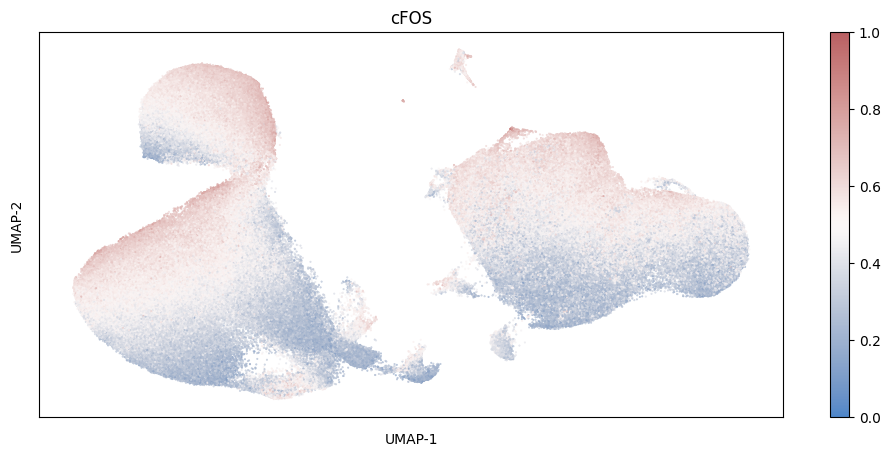

,umap-1,umap-2,cFOS
2025_8rounds_FullStack_BgSub_Z0_Hoechst_cp_masks_1,0.228157,7.915395,0.580628
2025_8rounds_FullStack_BgSub_Z0_Hoechst_cp_masks_2,8.830292,9.019276,0.553724
2025_8rounds_FullStack_BgSub_Z0_Hoechst_cp_masks_3,7.649678,8.250638,0.531977
2025_8rounds_FullStack_BgSub_Z0_Hoechst_cp_masks_4,7.828941,7.433479,0.520537
2025_8rounds_FullStack_BgSub_Z0_Hoechst_cp_masks_5,7.314023,8.382464,0.614261
...,...,...,...
2025_8rounds_FullStack_BgSub_Z0_Hoechst_cp_masks_457360,9.348147,4.879298,0.427696
2025_8rounds_FullStack_BgSub_Z0_Hoechst_cp_masks_457361,10.564658,9.325971,0.548757
2025_8rounds_FullStack_BgSub_Z0_Hoechst_cp_masks_457362,9.733813,5.916483,0.602607
2025_8rounds_FullStack_BgSub_Z0_Hoechst_cp_masks_457363,7.873325,9.132267,0.526096


In [ ]:
sm.pl.umap(adata, color =["cFOS"],figsize=[12,5],tight_layout=False,return_data=True)

/var/folders/vb/f8_hhkls73qf5938jf5w6rk9dds1_2/T/ipykernel_35262/2128693891.py:323: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



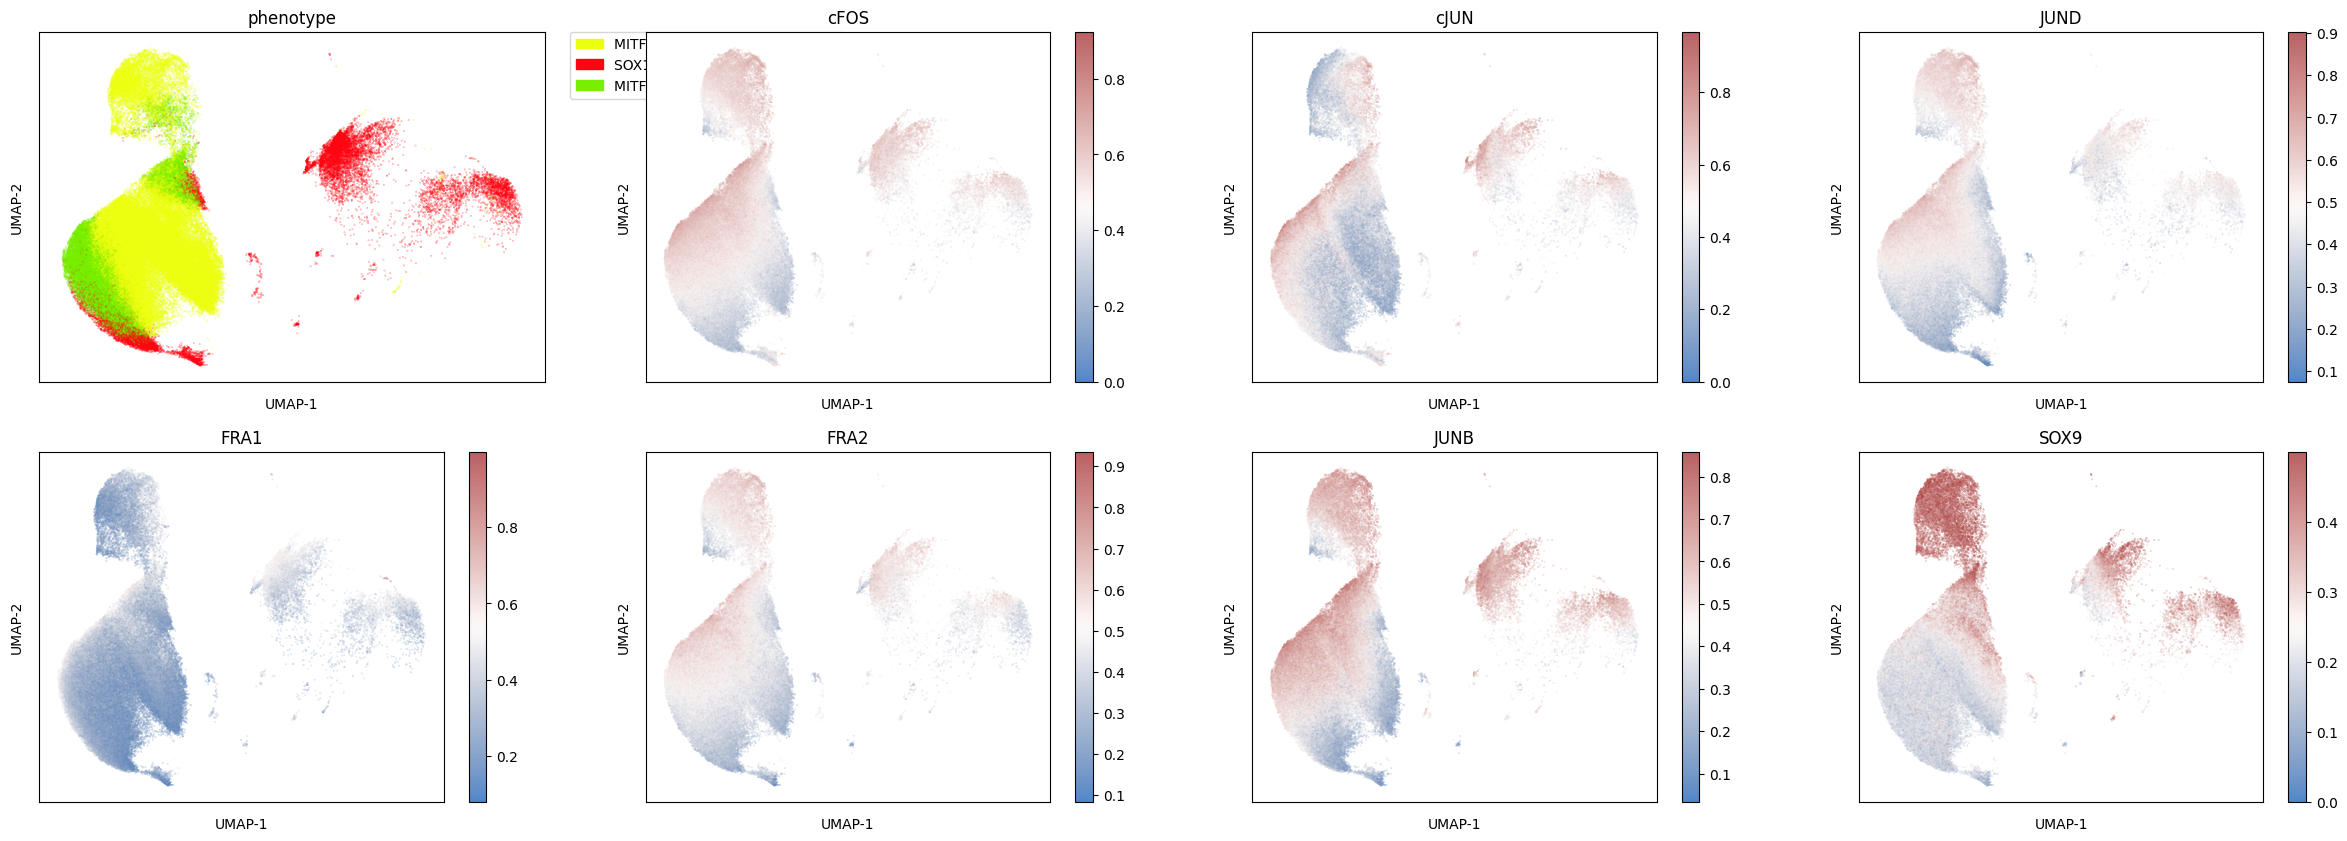

,umap-1,umap-2,phenotype,cFOS,cJUN,JUND,FRA1,FRA2,JUNB,SOX9
2025_8rounds_FullStack_BgSub_Z0_Hoechst_cp_masks_1,0.228157,7.915395,MITF+ SOX10+ PRAME+,0.580628,0.450379,0.534001,0.556914,0.590111,0.582457,0.433401
2025_8rounds_FullStack_BgSub_Z0_Hoechst_cp_masks_3,7.649678,8.250638,SOX10+ NGFR+,0.531977,0.485004,0.366434,0.508415,0.528454,0.581808,0.279273
2025_8rounds_FullStack_BgSub_Z0_Hoechst_cp_masks_4,7.828941,7.433479,SOX10+ NGFR+,0.520537,0.412703,0.422643,0.545260,0.286151,0.515454,0.450071
2025_8rounds_FullStack_BgSub_Z0_Hoechst_cp_masks_5,7.314023,8.382464,SOX10+ NGFR+,0.614261,0.535274,0.360218,0.511562,0.540369,0.537222,0.243469
2025_8rounds_FullStack_BgSub_Z0_Hoechst_cp_masks_8,6.480920,8.065512,SOX10+ NGFR+,0.539510,0.604307,0.368798,0.446005,0.445761,0.540084,0.386114
...,...,...,...,...,...,...,...,...,...,...
2025_8rounds_FullStack_BgSub_Z0_Hoechst_cp_masks_457312,7.389246,9.451011,SOX10+ NGFR+,0.634581,0.704069,0.572865,0.545195,0.591303,0.655237,0.385584
2025_8rounds_FullStack_BgSub_Z0_Hoechst_cp_masks_457328,9.105153,9.569517,SOX10+ NGFR+,0.634275,0.567161,0.570008,0.475244,0.576557,0.664994,0.394212
2025_8rounds_FullStack_BgSub_Z0_Hoechst_cp_masks_457340,8.657027,9.506276,SOX10+ NGFR+,0.591411,0.649656,0.558228,0.460122,0.571259,0.612969,0.473750
2025_8rounds_FullStack_BgSub_Z0_Hoechst_cp_masks_457352,7.647070,8.614200,SOX10+ NGFR+,0.570760,0.556217,0.514294,0.511683,0.523094,0.596976,0.360065


In [57]:
umap(adata, color =["phenotype",'cJUN','cFOS','FRA1','FRA2','JUNB','JUND','SOX9'], standardScale= True, 
    subset = ['MITF+ SOX10+ PRAME+','MITF+ SOX10+ NGFR+ PRAME+','SOX10+ NGFR+'], 
    figsize = (30,10), return_data=True)

In [40]:
umap(adata, color =["cJUN"], use_raw= True, subset = ['MITF+ SOX10+ PRAME+','MITF+ SOX10+ NGFR+ PRAME+','SOX10+ NGFR+'], return_data=True)

ValueError: Shape of passed values is (457364, 2), indices imply (457364, 3)

In [9]:
adata
#adata.obs.columns
#adata.var.index

AnnData object with n_obs × n_vars = 457364 × 17
    obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid', 'phenotype', 'cluster_neighborhood_radius15'
    uns: 'all_markers', 'expression_radius_15', 'gates', 'spatial_count_neighborhood_radius15', 'spatial_distance', 'spatial_interaction_15'
    layers: 'log', 'log1p_raw'

In [10]:
print(adata.log1p_raw)  # Access the raw expression matrix
#print(adata.raw.var)  # Access the variable names of the raw expression matrix

AttributeError: 'AnnData' object has no attribute 'log1p_raw'

In [8]:
# Ensure adata.raw exists
if adata.raw is not None:
    # Create a new AnnData object from adata.raw
    raw_adata = adata.raw.to_adata()

    # Apply log1p transformation to the raw data
    raw_adata.X = np.log1p(raw_adata.X)

    # Store the log1p-transformed data as a new layer in the original adata
    adata.layers["log1p_raw"] = raw_adata.X
else:
    print("adata.raw is not set. Please ensure raw data is available.")

In [16]:
adata.uns['gates']

,2025_8rounds_FullStack_BgSub_Z0_Hoechst_cp_masks
markers,
CD31,3.40
CD3D,4.90
CD4,3.46
CD45,3.40
FAP,3.15
FOXP3,5.00
FRA1,3.60
FRA2,4.00
JUNB,2.80


distplot version with gate vline

In [28]:
def distPlot(
    adata,
    layer=None,
    markers=None,
    subset=None,
    imageid='imageid',
    vline=None,
    vlinewidth=None,
    plotGrid=True,
    ncols=None,
    color=None,
    xticks=None,
    figsize=(5, 5),
    fontsize=None,
    dpi=200,
    saveDir=None,
    fileName='scimapDistPlot.png',
):
    """
    Parameters:
        ...
        vline (float, 'auto', 'gates', or None, optional):
            The x-coordinate of the vertical line to plot. If set to `None`, a vertical line is not plotted.
            Use 'auto' to draw a vline at the center point. Use 'gates' to draw a vline based on `adata.uns['gates']`.
        ...
    """
    # Subset data if needed
    if subset is not None:
        if isinstance(subset, str):
            subset = [subset]
        if layer == 'raw':
            bdata = adata.copy()
            bdata.X = adata.raw.X
            bdata = bdata[bdata.obs[imageid].isin(subset)]
        else:
            bdata = adata.copy()
            bdata = bdata[bdata.obs[imageid].isin(subset)]
    else:
        bdata = adata.copy()

    # Isolate the data
    if layer is None:
        data = pd.DataFrame(bdata.X, index=bdata.obs.index, columns=bdata.var.index)
    elif layer == 'raw':
        data = pd.DataFrame(bdata.raw.X, index=bdata.obs.index, columns=bdata.var.index)
    else:
        data = pd.DataFrame(
            bdata.layers[layer], index=bdata.obs.index, columns=bdata.var.index
        )

    # Keep only columns that are required
    if markers is not None:
        if isinstance(markers, str):
            markers = [markers]
        # Subset the list
        data = data[markers]

    # Auto identify rows and columns in the grid plot
    def calculate_grid_dimensions(num_items, num_columns=None):
        if num_columns is None:
            num_rows_columns = int(math.ceil(math.sqrt(num_items)))
            return num_rows_columns, num_rows_columns
        else:
            num_rows = int(math.ceil(num_items / num_columns))
            return num_rows, num_columns

    if plotGrid is False:
        # Create a figure and axis object
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
        # Loop through each column in the DataFrame and plot a KDE
        for column in data.columns:
            c = color.get(column, 'grey') if color else 'grey'
            data[column].plot.kde(ax=ax, label=column, color=c)
            if vline == 'auto':
                ax.axvline((data[column].max() + data[column].min()) / 2, color='black')
            elif vline == 'gates' and column in adata.uns['gates']:
                gate_value = adata.uns['gates'][column]
                print(f"Plotting gate for {column}: {gate_value}")  # Debugging print
                ax.axvline(gate_value, color='red', linestyle='--', linewidth=vlinewidth or 1)
            elif vline is not None:
                ax.axvline(vline, color='black')
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=fontsize)
        ax.tick_params(axis='both', which='major', width=1, labelsize=fontsize)
        plt.tight_layout()
        if xticks is not None:
            ax.set_xticks(xticks)
            ax.set_xticklabels([str(x) for x in xticks])
        if saveDir:
            plt.savefig(pathlib.Path(saveDir) / fileName)
        else:
            plt.show()
    else:
        # Calculate the number of rows and columns
        num_rows, num_cols = calculate_grid_dimensions(len(data.columns), num_columns=ncols)
        fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=figsize, dpi=dpi)
        axes = np.atleast_2d(axes)
        for i, column in enumerate(data.columns):
            c = color.get(column, 'grey') if color else 'grey'
            row_idx = i // num_cols
            col_idx = i % num_cols
            data[column].plot.kde(ax=axes[row_idx, col_idx], label=column, color=c)
            axes[row_idx, col_idx].set_title(column)
            if vline == 'auto':
                axes[row_idx, col_idx].axvline((data[column].max() + data[column].min()) / 2, color='gray', dashes=[2, 2], linewidth=1)
            elif vline == 'gates' and column in adata.uns['gates']:
                gate_value = adata.uns['gates'][column]
                print(f"Plotting gate for {column}: {gate_value}")  # Debugging print
                axes[row_idx, col_idx].axvline(gate_value, color='red', linestyle='--', linewidth=vlinewidth or 1)
            elif vline is not None:
                axes[row_idx, col_idx].axvline(vline, color='black')
        plt.tight_layout()
        if saveDir:
            if not os.path.exists(saveDir):
                os.makedirs(saveDir)
            full_path = os.path.join(saveDir, fileName)
            plt.savefig(full_path, dpi=300)
            plt.close()
            print(f"Saved plot to {full_path}")
        else:
            plt.show()

In [ ]:
if vline == 'gates' and column in adata.uns['gates']:
    print(f"Marker: {column}, Gate Value: {adata.uns['gates'][column]}")
    axes[row_idx, col_idx].axvline(adata.uns['gates'][column], color='red', linestyle='--', linewidth=vlinewidth or 1)

In [25]:
print(adata.uns['gates']['SOX10'])

KeyError: 'SOX10'